# Task 1: preRT segmentation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage
from monai.data import Dataset, DataLoader, ThreadDataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.utils import set_determinism
import os.path
import random
import torch

from monai.transforms import (
    Compose,
    LoadImaged,
    Compose,
    LoadImaged,
    RandSpatialCropd,
    EnsureChannelFirstd,
    ToTensord,
    Resized,
    AsDiscreted
)

In [10]:
data_path = "/cluster/projects/vc/data/mic/open/HNTS-MRG/train/"

In [11]:
data_preRT = []
for patient_num in os.listdir(data_path):
    patient = f"{data_path}{patient_num}"
    image = f"{patient}/preRT/{patient_num}_preRT_T2.nii.gz"
    mask = f"{patient}/preRT/{patient_num}_preRT_mask.nii.gz"
    
    data_preRT.append({"image": image, "label": mask})

print(len(data_preRT))

130


In [ ]:
set_determinism(seed=0)

training_data = data_preRT[:105]
validation_data = data_preRT[105:]

train_transforms = Compose(
     [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Resized(keys=["image", "label"], spatial_size=(128, 128, 64)),
        RandSpatialCropd(
            keys=["image", "label"],
            roi_size = [256, 256, 32],
            random_center = True,
            random_size = False
            ),
        AsDiscreted(keys=["label"], to_onehot=3),
        ToTensord(keys=["image", "label"])
    ]
)
train_ds = Dataset(data=training_data, transform=train_transforms)
val_ds = Dataset(data=validation_data, transform=train_transforms)


train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import gc
import time
from tqdm import tqdm 

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16,32,64,128,256),
    strides=(2, 2, 2, 2),
).to(device)

loss_function = DiceLoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters())
dice_metric = DiceMetric(include_background=True, reduction="mean")
max_epochs = 5

for epoch in range(max_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        epoch_loss = []
        correct = 0
        total = 0
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        
        training_losses = []
        for batch_data in tqdm(train_dataloader):
            images, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            #l = np.argmax(outputs[0], axis=0)
            #print(np.unique(l))
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            training_losses.append(loss.item())
            total += 1

            #print(f"train loss: {loss.item()}")
        
        #print(f"epoch {epoch + 1} average loss: {sum(epoch_loss)/total:.6f}")
        
        validation_losses = []
        with torch.no_grad():
            dice_scores = []
            for batch in tqdm(val_dataloader):
                images, labels = batch["image"].to(device), batch["label"].to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                #print(f"Validation loss: {loss}")
                validation_losses.append(loss.item())
                dice_metric(y_pred=outputs, y=labels)
            mean_dice = dice_metric.aggregate().item()
        print(f"Training mean loss: {np.mean(training_losses)}")
        print(f"Validation mean loss: {np.mean(validation_losses)}")
        print(f"Validation Mean Dice: {mean_dice:.6f}")





----------
epoch 1/5


100%|██████████| 7/7 [00:35<00:00,  5.10s/it]


Training mean loss: 0.7413935661315918
Validation mean loss: 0.7036685517856053
Validation Mean Dice: 0.504230
----------
epoch 2/5


100%|██████████| 7/7 [00:35<00:00,  5.07s/it]


Training mean loss: 0.6894709991686272
Validation mean loss: 0.6804247413362775
Validation Mean Dice: 0.501224
----------
epoch 3/5


100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Training mean loss: 0.6747442194909761
Validation mean loss: 0.6690952011517116
Validation Mean Dice: 0.549159
----------
epoch 4/5


100%|██████████| 7/7 [00:36<00:00,  5.18s/it]


Training mean loss: 0.6617673617420774
Validation mean loss: 0.6499432921409607
Validation Mean Dice: 0.531399
----------
epoch 5/5


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]

Training mean loss: 0.6520937067089658
Validation mean loss: 0.6403035947254726
Validation Mean Dice: 0.534077


In [35]:
image = val_ds[1]["image"]
label = val_ds[1]["label"]
image_with_batch = np.expand_dims(image, axis=0)
image_with_batch = torch.from_numpy(image_with_batch).float()
label_remove_one_hot = np.argmax(label, axis=0)

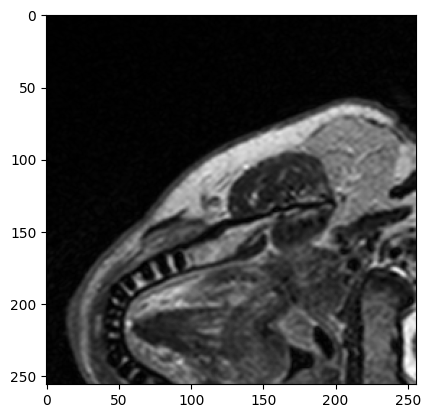

In [36]:
image_vis = np.squeeze(image, axis=0)
plt.imshow(image_vis[:, :, 20], cmap='gray')

In [37]:
image_with_batch = image_with_batch.to(device)


model.eval()
with torch.no_grad():  
    output = model(image_with_batch)
    output = output.cpu().numpy()
output_label_vis = np.squeeze(output, axis=0)
output_remove_one_hot = np.argmax(output_label_vis, axis=0)
print(np.unique(output_remove_one_hot))
positions = np.where(output_remove_one_hot == 1)
print(positions)

[0 1 2]
(array([ 82,  82,  82, ..., 251, 251, 251]), array([211, 213, 213, ..., 152, 153, 155]), array([13, 13, 19, ..., 21, 19, 21]))


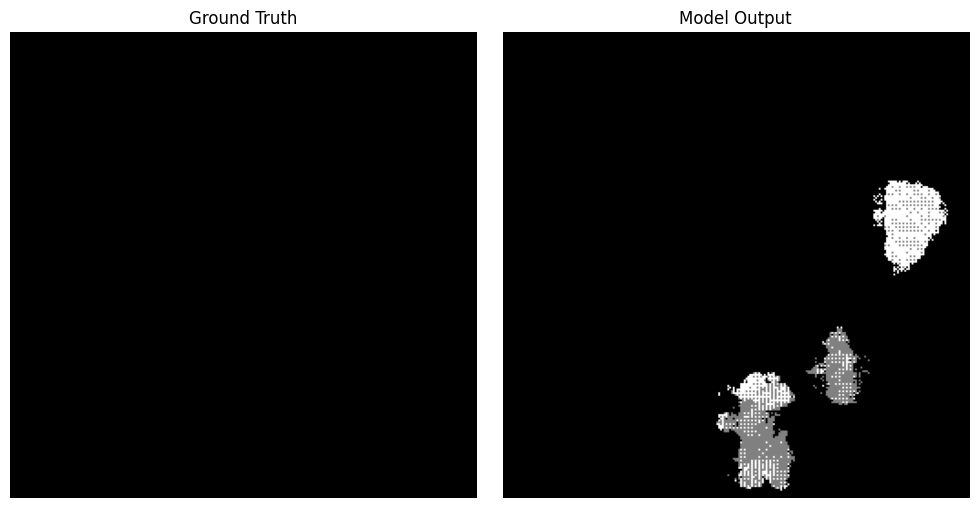

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  
plt.title("Ground Truth")
plt.imshow(label_remove_one_hot[:, :, 18], cmap='gray')
plt.axis('off') 

plt.subplot(2, 2, 2) 
plt.title("Model Output")
plt.imshow(output_remove_one_hot[:, :, 18], cmap='gray')
plt.axis('off') 

plt.tight_layout() 
plt.show()
